# The evolving distribution of vulnerability discovery difficulty

In this notebook, we ask how the distribution of vulnerability discovery difficulty changes as a piece of software becomes 'hardened'. We see that regardless of the initial distribution, the profile eventually converges on an decaying exponential-like shape. This leads us to believe that the distribution is determined less by the process of vulnerability creation and more by the process of vulnerability discovery.

We first define a function which simulates discovery and patch of vulnerabilites, showing the distribution at a number of points in the software's evolution. Then we execute the function with a variety of initial vulnerability distributions.

In [1]:
%pylab inline
import circlesquare
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


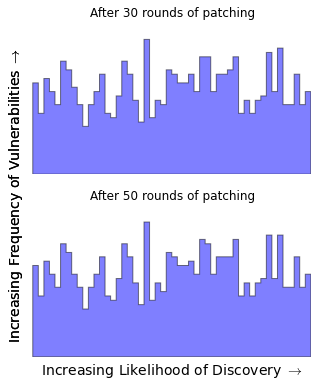

In [4]:
def plots_for_function(initial_dist=np.random.rand,  
                       stop_points=[30, 50],
                       max_area=.01, num_pts=1000,
                       alpha=.5, method='stack'):
    """Simulate a single actor discovering a bug and patching it.
    
    Parameters
    ----------
    initial_dist : numpy probability distribution function 
       This function drives the initial distribution of the 
       vulnerability discovery likelihoods.
       
    stop points : list of integers
       The rounds at which the distribution will be plotted.
       Sets the maximum number of rounds as equal to its largest value.
       Must be sorted.
       
    max_area : float
       The greatest likelihood that any of the vulnerabilities will 
       take on. Multiplied by samples from the initial distribution
       to create circles.
       
    num_pts : int
       Total number of vulnerabilities to include in the simulation.
       
    alpha : float
       Transparency of the histogram
       
    method : 'stack' or 'overlay'
       If 'stack' will give each stop point its own axis
       If 'overlay' will put all stop points on the same axis
       
    """
    product = circlesquare.CircleSquare()
    product.make_pts(num_pts)
    
    seeker = product.new_interface('Seeker')
    seeker.make_circles(initial_dist=initial_dist, max_area=max_area)

    if method == 'overlay':
        plt.figure(figsize=(5,5))
        for stop_point in stop_points:
            if stop_point > 0:
                seeker.harden(stop_point-product.rounds_hardened)
            plt.hist(seeker.circles.area.values, bins=50, histtype='stepfilled', 
                     alpha=alpha, label="%i rounds"%stop_point);
        plt.box('off')
        plt.yticks([])
        plt.xticks([])
        plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
        plt.ylabel(r'Increasing Frequency of Vulnerabilities $\rightarrow$', fontsize=14)
            
    if method == 'stack':
        plt.figure(figsize=(5,6))
        for i, stop_point in enumerate(stop_points):
            if stop_point > 0:
                seeker.harden(stop_point-product.rounds_hardened)
            plt.subplot(len(stop_points), 1, i+1)
            plt.hist(seeker.circles.area.values, bins=50, histtype='stepfilled', 
                     alpha=alpha, label="%i rounds"%stop_point);
            plt.box('off')
            plt.yticks([])
            plt.xticks([])
            plt.title('After %i rounds of patching'%stop_point)
            plt.figtext(.08, .5, r'Increasing Frequency of Vulnerabilities $\rightarrow$', 
                        fontsize=14, rotation=90, ha='center', va='center')

    plt.xlabel(r'Increasing Likelihood of Discovery $\rightarrow$', fontsize=14)

    return seeker, product

plots_for_function();

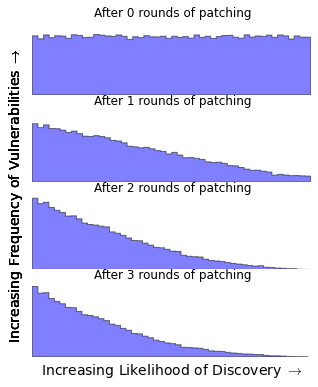

In [5]:
seeker, product = plots_for_function(lambda: np.random.beta(1,1), 
                           stop_points=[0,1,2,3],
                           num_pts=100000,
                           max_area=1)

# A range of initial distributions

The expected output distribution after a number of tests follows the expression $(1-likelihood)^n$ where $n$ is the number of rounds of patching that have been performed.

Here we'll use a beta function to illustrate how this expected outcome dominates any initial distribution we might start with.

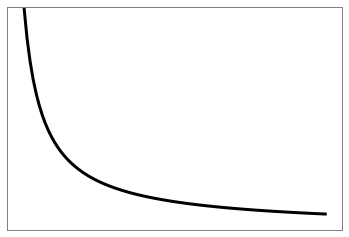

In [74]:
def draw_beta(a, b, ax):

    xs = np.linspace(.05,.95,100)
    ys = scipy.stats.beta(a, b).pdf(xs)
    ax.plot(xs, ys/max(ys), 'k', linewidth=3)

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.setp(ax.spines.values(), color='grey')
    
    #return rounds_required, beta
    
draw_beta(.1,1,plt.subplot())

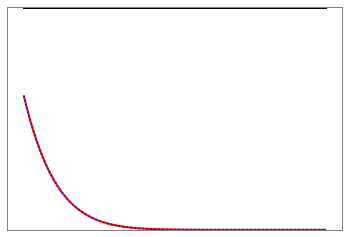

In [90]:
def draw_expected(a,b, ax, rounds=5):
    
    xs = np.linspace(.05,.95,100)
    betas = scipy.stats.beta(a, b).pdf(xs)
    bys = betas/max(betas)
    
    thetas = (1-xs)**rounds
    ys = thetas * bys
    
    ax.plot(xs, bys, 'k', linewidth=3)
    ax.plot(xs, ys, 'r', linewidth=2)
    
    
    #plot the 1,1 condition
    b1 = scipy.stats.beta(1, 1).pdf(xs)
    ax.plot(xs, b1*thetas, 'b:',linewidth=2)
    
    
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.setp(ax.spines.values(), color='grey')
    
draw_expected(1,1,plt.subplot(),10)

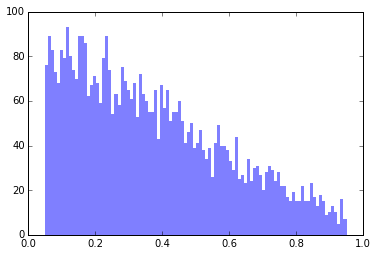

In [100]:
def sim_beta(a,b, ax, max_area=1, rounds=10, num_pts=10000):
    
    initial_dist = lambda: np.random.beta(a,b)
    
    product = circlesquare.CircleSquare()
    product.make_pts(num_pts)
    
    seeker = product.new_interface('Seeker')
    seeker.make_circles(initial_dist=initial_dist, max_area=max_area)

    seeker.harden(rounds)
    
    xs = np.linspace(.05,.95,101)
    ys, _ = np.histogram(seeker.circles.area.values, bins=xs)

    
    #ax.hist(, bins=50, histtype='stepfilled', 
    #         alpha=.5, label="beta(%i,%i)"%(a,b)); 
    plt.bar(xs[:-1],ys,width=xs[1]-xs[0], linewidth=0, alpha=.5)
    
sim_beta(1,1,plt.subplot())

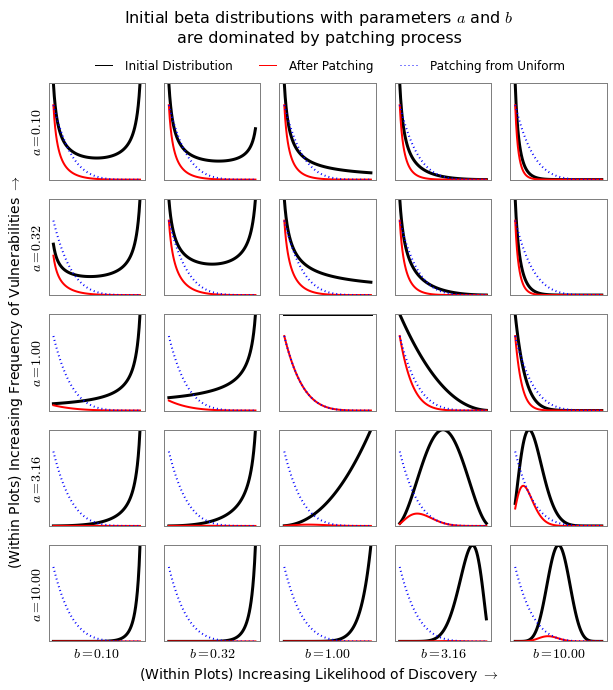

In [119]:
nrows = ncols = 5
plt.figure(figsize=(10,10))
plotnum = 0
for row, a in enumerate(np.logspace(-1,1,nrows)):
    for col, b in enumerate(np.logspace(-1,1,ncols)):
        ax = plt.subplot(nrows,ncols, plotnum+1)
        #plot_dists(row,col,ax)
        #draw_beta(row,col,ax)
        #sim_beta(row, col, ax)
        draw_expected(a,b,ax)
        plotnum += 1
        if col == 0:
            plt.ylabel('$a=%.02f$'%a, fontsize=14)
        if row == nrows-1:
            plt.xlabel('$b=%.02f$'%b, fontsize=14)
            
        if (col==nrows/2) & (row==0):
            plt.plot(np.nan,np.nan, 'k', label='Initial Distribution')
            plt.plot(np.nan,np.nan, 'r', label='After Patching')
            plt.plot(np.nan,np.nan, 'b:', label='Patching from Uniform')
            legend = plt.legend(frameon=False, loc='lower center', ncol=3, bbox_to_anchor=(.5,1))
        
            

plt.figtext(.5,.96,'Initial beta distributions with parameters $a$ and $b$\nare dominated by patching process', 
            ha='center', fontsize=16)

plt.figtext(.08, .5, r'(Within Plots) Increasing Frequency of Vulnerabilities $\rightarrow$', 
                        fontsize=14, rotation=90, ha='center', va='center')

plt.figtext(.5, .08, r'(Within Plots) Increasing Likelihood of Discovery $\rightarrow$', 
                        fontsize=14, ha='center', va='center')

